# Calibration
This notebook could perfrom calibration to the connected ime board step by step.
First thing first, in order to successful perform the calibration, the "CAL_COMPILE" in the "global.h" header file should be set to "true" for enabling the calibration function. You may disable the some functions to fit the Arduino's programe storage space, such as setting the "DIAG_COMPILE", "DIAG_VERBOSE", "ADADC_COMPILE", "SW_COMPILE", and "EEPROM_COMPILE" to false (in the "global.h"). 

### Step 1. Import required libiaries

In [1]:
import sys
import serial
import numpy as np
from math import log
from math import sqrt
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tnrange, tqdm_notebook
import scipy.io as sio
from sklearn.linear_model import LinearRegression
import csv

### Step 2. Define some useful functions

In [2]:
# fundemental serial communication function
def write_and_read(ser, cmd):
    to_write = cmd+"\n"
    ser.write(to_write.encode())
    res = ser.readline().decode().rstrip('\r\n')
    print('({}): OK ({})'.format(to_write.rstrip('\n'), res) )
    return res

# flush the serial buffer (continuously receieve and print serial port until a timeout occurred)
def flush_serial(ser):
    while True:
        line = ser.readline().decode().rstrip('\r\n')
        if line == "":
            break
        else:
            print(line)

RANGE_5V_UNI        =  "5V_UNI"
RANGE_10V_UNI       =  "10V_UNI"
RANGE_5V_BIP        =  "5V_BIP"
RANGE_10V_BIP       =  "10V_BIP"
RANGE_20mA_UNI      =  "20mA_UNI"
RANGE_24mA_UNI      =  "24mA_UNI"
RANGE_4_24mA        =  "4_24mA"
RANGE_20mA_BIP      =  "20mA_BIP"
RANGE_24mA_BIP      =  "24mA_BIP"
RANGE_22mA_OVR      =  "22mA_OVR"

# configure channel output mode and range, taking the modes listed above
def config_channel_mode(ser, slot, ch, md):
    cmd = "{}:{}:CONF:".format(slot,ch)+md
    write_and_read(ser, cmd)
    # print(cmd)

# set the output current of a particular channel (valid only in current mode)
def set_current(ser, slot, ch, value, md):
    if md==RANGE_20mA_UNI or md==RANGE_24mA_UNI or md==RANGE_4_24mA or md==RANGE_20mA_BIP or md==RANGE_24mA_BIP or md==RANGE_22mA_OVR:
        dacCode = convert_dac_code(value, md)
        if dacCode>=0:
            cmd = "{}:{}:CURR:{}".format(slot, ch, dacCode)
            write_and_read(ser, cmd)
        else:
            print("Error: Value out of range!")
    else:
        print("Mode error: Channel {} is not in current mode".format(ch))

# set the output voltage of a particular channel (valid only in voltage)
def set_voltage(ser, slot, ch, value, md):
    if md==RANGE_5V_UNI or md==RANGE_10V_UNI or md==RANGE_5V_BIP or md==RANGE_10V_BIP:
        dacCode = convert_dac_code(value, md)
        if dacCode>=0:
            cmd = "{}:{}:VOLT:{}".format(slot, ch, dacCode)
            write_and_read(ser, cmd)
        else:
            print("Error: Value out of range!")
    else:
        print("Mode error: Channel {} in Slot {} is not in voltage mode".format(ch, slot))

AD5753_REFIN           = "AD_REFIN"
AD5753_REFGND          = "AD_REFGND"
AD5753_ISENSE          = "AD_CURR"
AD5753_LOADP           = "AD_VLOAD"
MAX11254_CURRENT       = "MAX_CURR"
MAX11254_SENSE_VOLTAGE = "MAX_VSENSE"
MAX11254_LOAD_VOLTAGE  = "MAX_VLOAD"

# perform a measurement (current or voltage). Avilable measurement types are listed above. 
def measure(ser, slot, ch, md):
    cmd = "{}:{}:MEAS:".format(slot,ch)+md
    adc_code = int(write_and_read(ser, cmd))
    res = convert_adc_code(adc_code, md)
    return res

INTERNAL_LOAD = "INTERNAL"
EXTERNAL_LOAD = "EXTERNAL"

# toggle the output target of a particular channel, internal test resistor or external load
def toggle_output_switch(ser, slot, ch, value):
    cmd = "{}:{}:REFR:{}".format(slot, ch, value)
    write_and_read(ser, cmd)
    return

# reset the boards
def reset(ser):
    cmd = "*RST"
    write_and_read(ser, cmd)
    flush_serial(ser)
    sleep(1)

# convert demand setting value (current or voltage) to the corresponding dac code
def convert_dac_code(value, md):
    if md == RANGE_5V_UNI and value >= 0 and value <= 5:
        return int(value*65535/5)
    elif md == RANGE_10V_UNI and value >= 0 and value <= 10:
        return int(value*65535/10)
    elif md == RANGE_5V_BIP and value >= -5 and value <= 5:
        return int(value*32767/5)+32768
    elif md == RANGE_10V_BIP and value >= -10 and value <= 10:
        return int(value*32765/10)+32768
    elif md == RANGE_20mA_UNI and value >= 0 and value <= 20:
        return int(value*65535/20)
    elif md == RANGE_24mA_UNI and value >= 0 and value <= 24:
        return int(value*65535/24)
    elif md == RANGE_4_24mA_UNI and value >= 4 and value <= 24:
        return int((value-4)*65535/20)
    elif md == RANGE_20mA_BIP and value >= -20 and value <= 20:
        return int(value*32767/20)+32768
    elif md == RANGE_24mA_BIP and value >= -24 and value <= 24:
        return int((value+1)*65535/23)+32768
    else:
        return -1

# convert measured adc code to actual value
def convert_adc_code(value, md):
    if md == AD5753_REFIN:
        return value/4096*2.75
    elif md == AD5753_REFGND:
        return value/4096*2.5
    elif md == AD5753_ISENSE:
        return value/4096*2.5
    elif md == AD5753_LOADP:
        return 30*value/4096-15
    elif md == MAX11254_CURRENT:
        return (value/8388608-1)*25
    elif md == MAX11254_SENSE_VOLTAGE:
        return (value/8388608-1)*25
    elif md == MAX11254_LOAD_VOLTAGE:
        return (value/8388608-1)*25
    else:
        return -1

# set the four calibration parameters of a particular channel
def set_calibration_params(ser, slot, ch, gain_i, offset_i, gain_v, offset_v):
    cmd = "{}:{}:CALS:{},{},{},{},".format(slot, ch, gain_i, offset_i, gain_v, offset_v)
    # print(cmd)
    write_and_read(ser, cmd)

# reset all the currently stored calibration parameters
def reset_calibration(ser):
    cmd = "*CALC"
    write_and_read(ser, cmd)

# query the current slot and channel availbility
def get_occupancy(ser):
    cmd = "*OCC?"
    write_and_read(ser, cmd)
    occupancy = []
    for slot in range(16):
        occupancy.append(int(ser.readline().decode().rstrip('\r\n'),2))
        if (occupancy[slot]>0):
            print("Slot {}:".format(slot), end=" ")
            for ch in range(8):
                if ( occupancy[slot]&(1<<ch) ):
                    print("Ch {}: good,".format(ch), end=" ")
                else:
                    print("Ch {}: bad,".format(ch), end=" ")
            print("")
        else:
            print("Slot {} is not used".format(slot))
    occupancy = np.asarray(occupancy)
    return occupancy

In [3]:
# save an obatined calibration file
def save_csv(data, filename):
    with open(filename, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')
        nRep = int((data.shape[1]-1)/3)
        firstLine = ['dac_code']
        for idx in range(nRep):
            firstLine.append('iSense')
            firstLine.append('VSense')
            firstLine.append('VLoad')
        csv_writer.writerow(firstLine)
        csv_writer.writerows(data)

# read a calibration file
def read_csv(filename):
    data = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        isFirstLine = True
        for row in reader:
            if not isFirstLine:
                data.append([int(i) for i in row])
            isFirstLine = False
        data = np.asarray(data)
    return data

In [4]:
# evalute a calibration files, return scores such as the R-square, the resolution, the integration nonlinearlity, and the residual
def evalute(x,data,std):
    x = x.reshape((-1,1))
    reg = LinearRegression().fit(x, data)
    R2 = reg.score(x,data)
    residual = data-reg.predict(x)
    inl = max(abs(residual))/(max(data)/65536)
    MSE = np.square(residual).mean()
    res = log(MSE/max(data),2)
    return R2, res, inl, residual

In [5]:
# plot a saved calibration result.
def plot_cal(slot, ch, file_prefix):
    filename = file_prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
    cal1 = read_csv(filename)
    x1 = cal1[:,0]
    v = (x1-32768)/32768*10
    length = cal1.shape[1]
    n = len(range(2,length,3))
    vSense_avg = 0
    for idx in range(2,length,3):
        vSense_avg = vSense_avg+((cal1[:,idx])/8388608-1)*25
    vSense_avg = vSense_avg/n
    vLoad_avg = 0
    for idx in range(3,length,3):
        vLoad_avg = vLoad_avg+((cal1[:,idx])/8388608-1)*25
    vLoad_avg = vLoad_avg/n

    fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
    axs[0].plot(x1,v,label = 'v')
    axs[0].plot(x1,vSense_avg,label = 'vSense')
    # axs[0].plot(x1,vLoad,label = 'vLoad')
    axs[0].set_xlim(0,65536)
    axs[0].set_ylabel('Voltage')
    axs[0].set_title('Calibration: Channel {}, Voltage'.format(ch))
    axs[0].legend()
    R2, res, inl, residual_vSense = evalute(x1,vSense_avg,v)
    axs[0].text(8000, -10, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.3}LSBs'.format(R2, res, inl), fontsize=15)
    # axs[1].plot(x1,vLoad-v,label='vLoad-v')
    axs[1].plot(x1,vSense_avg-v,label='vSense-v')
    axs[1].set_xlim(0,65536)
    axs[1].set_xlabel('DAC Code')
    axs[1].set_ylabel('Residual')
    axs[1].legend()

    filename = file_prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
    cal2 = read_csv(filename)
    x2 = cal2[:,0]
    i = (x1-32768)/32768*20
    iSense_avg = 0
    for idx in range(1,length,3):
        iSense_avg = iSense_avg+((cal2[:,idx])/8388608-1)*2500/49.8
    iSense_avg = iSense_avg/n

    fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
    axs[0].plot(x2,i,label = 'i')
    axs[0].plot(x2,iSense_avg,label = 'iSense')
    axs[0].set_xlim(0,65536)
    axs[0].set_ylabel('Current')
    axs[0].set_title('Calibration: Channel {}, Current'.format(ch))
    axs[0].legend()
    R2, res, inl, residual_iSense = evalute(x2,iSense_avg,i)
    axs[0].text(5000, -20, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.5}LSBs'.format(R2, res, inl), fontsize=15)
    axs[1].plot(x1,iSense_avg-i,label='iSense-i')
    axs[1].set_xlim(0,65536)
    axs[1].set_xlabel('DAC Code')
    axs[1].set_ylabel('Residual')
    axs[1].legend()

### Step 3. Some warm up examples

In [6]:
# example of using "*OCC" command to get occupancy of the current board
with serial.Serial('COM3', 500000, timeout=2) as ser: 
    flush_serial(ser) #flush serial port
    occupancy = get_occupancy(ser)

(*OCC?): OK (Occupancy:)
Slot 0 is not used
Slot 1 is not used
Slot 2 is not used
Slot 3 is not used
Slot 4 is not used
Slot 5 is not used
Slot 6 is not used
Slot 7 is not used
Slot 8: Ch 0: good, Ch 1: bad, Ch 2: good, Ch 3: good, Ch 4: good, Ch 5: good, Ch 6: good, Ch 7: bad, 
Slot 9 is not used
Slot 10 is not used
Slot 11 is not used
Slot 12 is not used
Slot 13 is not used
Slot 14 is not used
Slot 15 is not used


In [7]:
# example of using the above defined commands to configure a particular channel mode, set a output value, and to perform a measurement. 
with serial.Serial('COM3', 500000, timeout=2) as ser: 
    # flush_serial(ser) #flush serial port
    slot = 8
    ch = 0
    md = RANGE_5V_UNI
    config_channel_mode(ser, slot, ch, md) #config channel range
    set_voltage(ser, slot, ch, 1, md) #set voltage
    data = measure(ser, slot, ch, MAX11254_SENSE_VOLTAGE) #make a measurement
    print("result:{}".format(data))

(8:0:CONF:5V_UNI): OK (DONE)
(8:0:VOLT:13107): OK (DONE)
(8:0:MEAS:MAX_VSENSE): OK (8724216)
result:1.0001897811889648


### Step 4. Calibration
#### (a) reset all the stored calibration and perform a whole board scanning

In [67]:
with serial.Serial('COM3', 500000, timeout=3) as ser: 
    flush_serial(ser)
    occupancy = get_occupancy(ser)
    flush_serial(ser)
    reset_calibration(ser) # reset the current stored calibration
    write_and_read(ser,"*CAL")
    clear_output()
    nCal = 256
    prefix = 'calibration/uncalibrated/'
    for slot in tqdm_notebook(range(16), desc="Total"):
        for ch in tqdm_notebook(range(8), desc="Slot {}".format(slot), leave=False):
            if ( (occupancy[slot]&(1<<ch)) ):
                cal1 = []
                cal2 = []
                for index in tqdm_notebook(range(nCal), desc='Channel {}:Voltage'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal1.append(np.asarray(res.split(","),int))
                cal1 = np.asarray(cal1)
                for index in tqdm_notebook(range(nCal), desc='Channel {}:Current'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal2.append(np.asarray(res.split(","),int))
                cal2 = np.asarray(cal2)
                filename = prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
                save_csv(cal1, filename)
                filename = prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
                save_csv(cal2, filename)
    reset(ser)


(*RST): OK (Resetting...)
---- Controller Loaded ----
Slot 0 is not used.
Slot 1 is not used.
Slot 2 is not used.
Slot 3 is not used.
Slot 4 is not used.
Slot 5 is not used.
Slot 6 is not used.
Slot 7 is not used.
Slot 8: Ch 0: Good N, Ch 1: Bad, Ch 2: Good N, Ch 3: Good N, Ch 4: Good N, Ch 5: Good N, Ch 6: Good N, Ch 7: Bad, 
---- DB(8) Mon. Reset ----
Slot 9 is not used.
Slot 10 is not used.
Slot 11 is not used.
Slot 12 is not used.
Slot 13 is not used.
Slot 14 is not used.
Slot 15 is not used.
Found 1 daughterboard(s), and 6 Channel(s) in total.
----   Monitor Reset   ----
---> Setup finished successfully.


#### (b) have a look at the uncalibrated scanning results

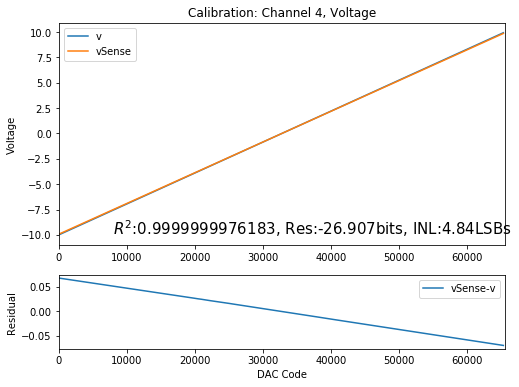

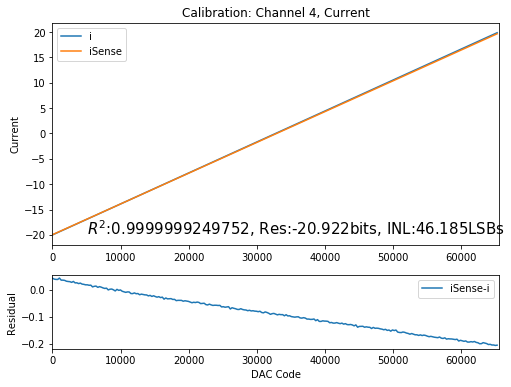

In [68]:
slot = 8
ch = 4
prefix = 'calibration/uncalibrated/'
plot_cal(slot, ch, prefix)

#### (c) calculate calibration parameters from the scanning and save them to the onboard eeprom

In [69]:
with serial.Serial('COM3', 500000, timeout=3) as ser:
    flush_serial(ser)
    prefix = 'calibration/uncalibrated/'
    for slot in range(16):
        for ch in range(8):
            if ( (occupancy[slot]&(1<<ch)) ):
                print("Slot{} Ch {}".format(slot,ch))
                filename = prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
                cal1 = read_csv(filename)
                x1 = cal1[:,0]
                v = (x1-32768)*102.4+8388608
                length = cal1.shape[1]
                n = len(range(2,length,3))
                vSense_avg = 0
                for idx in range(2,length,3):
                    vSense_avg = vSense_avg+cal1[:,idx]
                vSense_avg = vSense_avg/n
                vLoad_avg = 0
                for idx in range(3,length,3):
                    vLoad_avg = vLoad_avg+cal1[:,idx]
                vLoad_avg = vLoad_avg/n

                x = vSense_avg.reshape((-1,1))
                reg = LinearRegression().fit(x, v)
                # gain_v = int(reg.coef_*(1<<23))
                gain_v = int( (reg.coef_*10-9)*(1<<23) )
                offset_v = int(np.mean(v-vSense_avg*reg.coef_))+(1<<23)
                print(gain_v,offset_v)

                filename = prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
                cal2 = read_csv(filename)
                x2 = cal2[:,0]
                i = (x1-32768)*102.4*2.49/2.5+8388608
                iSense_avg = 0
                for idx in range(1,length,3):
                    iSense_avg = iSense_avg+cal2[:,idx]
                iSense_avg = iSense_avg/n

                x = iSense_avg.reshape((-1,1))
                reg = LinearRegression().fit(x, i)
                gain_i = int( (reg.coef_*10-9)*(1<<23) )
                offset_i = int(np.mean(i-iSense_avg*reg.coef_))+(1<<23)
                print(gain_i,offset_i)

                set_calibration_params(ser, slot, ch, gain_i, offset_i, gain_v, offset_v)

Slot8 Ch 0
8922462 8335734
9528207 8301911
(8:0:CALS:9528207,8301911,8922462,8335734,): OK (9528207 8301911 8922462 8335734 Done)
Slot8 Ch 2
8949996 8332827
9208814 8357394
(8:2:CALS:9208814,8357394,8949996,8332827,): OK (9208814 8357394 8949996 8332827 Done)
Slot8 Ch 3
8948901 8332690
9720620 8275099
(8:3:CALS:9720620,8275099,8948901,8332690,): OK (9720620 8275099 8948901 8332690 Done)
Slot8 Ch 4
8970459 8330681
8903347 8352113
(8:4:CALS:8903347,8352113,8970459,8330681,): OK (8903347 8352113 8970459 8330681 Done)
Slot8 Ch 5
8964247 8331174
9257570 8357431
(8:5:CALS:9257570,8357431,8964247,8331174,): OK (9257570 8357431 8964247 8331174 Done)
Slot8 Ch 6
8962457 8331366
9448106 8329876
(8:6:CALS:9448106,8329876,8962457,8331366,): OK (9448106 8329876 8962457 8331366 Done)


#### (d) now, do the scanning again and save the obtained results in a different folder

In [8]:
with serial.Serial('COM3', 500000, timeout=3) as ser: 
    flush_serial(ser)
    occupancy = get_occupancy(ser)
    flush_serial(ser)
    write_and_read(ser,"*CAL")
    clear_output()
    nCal = 256
    prefix = 'calibration/calibrated/' # this time, save the file into a different folder
    for slot in tqdm_notebook(range(16), desc="Total"):
        for ch in tqdm_notebook(range(8), desc="Slot {}".format(slot), leave=False):
            if ( (occupancy[slot]&(1<<ch)) ):
                cal1 = []
                cal2 = []
                for index in tqdm_notebook(range(nCal), desc='Channel {}:Voltage'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal1.append(np.asarray(res.split(","),int))
                cal1 = np.asarray(cal1)
                for index in tqdm_notebook(range(nCal), desc='Channel {}:Current'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal2.append(np.asarray(res.split(","),int))
                cal2 = np.asarray(cal2)
                filename = prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
                save_csv(cal1, filename)
                filename = prefix+'Slot{}_Ch{}_cal2.csv'.format(slot,ch)
                save_csv(cal2, filename)
    reset(ser)


(*RST): OK (Resetting...)
---- Controller Loaded ----
Slot 0 is not used.
Slot 1 is not used.
Slot 2 is not used.
Slot 3 is not used.
Slot 4 is not used.
Slot 5 is not used.
Slot 6 is not used.
Slot 7 is not used.
Slot 8: Ch 0: Good Y, Ch 1: Bad, Ch 2: Good Y, Ch 3: Good Y, Ch 4: Good Y, Ch 5: Good Y, Ch 6: Good Y, Ch 7: Bad, 
---- DB(8) Mon. Reset ----
Slot 9 is not used.
Slot 10 is not used.
Slot 11 is not used.
Slot 12 is not used.
Slot 13 is not used.
Slot 14 is not used.
Slot 15 is not used.
Found 1 daughterboard(s), and 6 Channel(s) in total.
----   Monitor Reset   ----
---> Setup finished successfully.


#### (e) finally, have a look at the scanning results after calibration

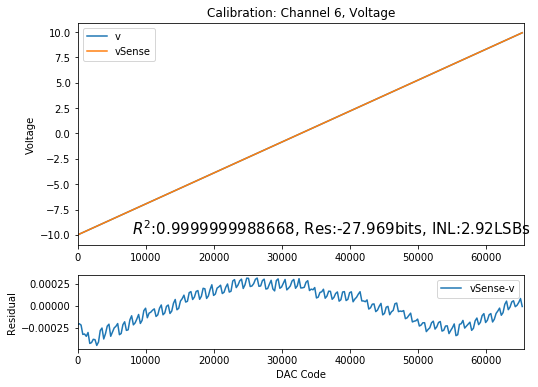

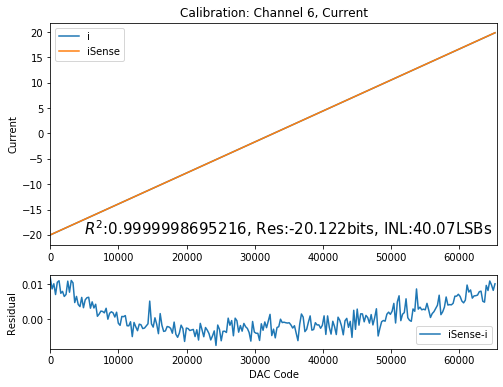

In [15]:
slot = 8
ch = 6
prefix = 'calibration/calibrated/'
plot_cal(slot, ch, prefix)

8922343 -52844


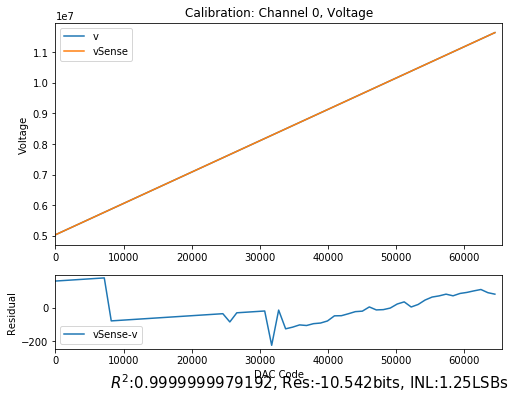

In [47]:
slot = 8
ch = 0
file_prefix = 'calibration/uncalibrated/'
filename = file_prefix+'Slot{}_Ch{}_cal1.csv'.format(slot,ch)
cal1 = read_csv(filename)
x1 = cal1[:,0]
# v = (x1-32768)/32768*10
v = (x1-32768)*102.4+8388608
length = cal1.shape[1]
n = len(range(2,length,3))
vSense_avg = 0
for idx in range(2,length,3):
    vSense_avg = vSense_avg+cal1[:,idx]
vSense_avg = vSense_avg/n

x = vSense_avg.reshape((-1,1))
reg = LinearRegression().fit(x, v)
# gain_v = int(reg.coef_*(1<<23))
gain_v = int( (reg.coef_*10-9)*(1<<23) )
offset_v = int(np.mean(v-vSense_avg*reg.coef_))+(1<<23)
print(gain_v,offset_v)

vSense_avg = vSense_avg*(gain_v/8388608/10+0.9)+offset_v

fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(x1,v,label = 'v')
axs[0].plot(x1,vSense_avg,label = 'vSense')
axs[0].set_xlim(0,65536)
axs[0].set_ylabel('Voltage')
axs[0].set_title('Calibration: Channel {}, Voltage'.format(ch))
axs[0].legend()
R2, res, inl, residual_vSense = evalute(x1,vSense_avg,v)
axs[0].text(8000, -10, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.3}LSBs'.format(R2, res, inl), fontsize=15)
axs[1].plot(x1,v-vSense_avg,label='vSense-v')
axs[1].set_xlim(0,65536)
axs[1].set_xlabel('DAC Code')
axs[1].set_ylabel('Residual')
axs[1].legend()